# Fake News Project
The goal of this project is to create a fake news prediction system. Fake news is a major problem that can have serious negative effects on how people understand the world around them. You will work with a dataset containing real and fake news in order to train a simple and a more advanced classifier to solve this problem. This project covers the full Data Science pipeline, from data processing, to modelling, to visualization and interpretation.
## Part 1 Data Processing

### Task 1

In [17]:
import pandas as pd
import re
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.tokenize.regexp import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.lm import Vocabulary
from nltk.probability import FreqDist
from functools import reduce
from cleantext import clean

def clean_text(text):
  clean_text = re.sub(r'([A-Z][A-z]+.?) ([0-9]{1,2}?), ([0-9]{4})', '<DATE>', text)
  clean_text = clean(clean_text,
    lower=True,
    no_urls=True, replace_with_url="<URL>",
    no_emails=True, replace_with_email="<EMAIL>",
    no_numbers=True, replace_with_number= r"<NUM>",
    no_currency_symbols=True, replace_with_currency_symbol="<CUR>",
    no_punct=True, replace_with_punct="",
    no_line_breaks=True 
  )
  return clean_text

def rmv_stopwords(tokens):
  stop_words = set(nltk.corpus.stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]
  return tokens

def stem_tokens(tokens):
  stemmer=PorterStemmer()
  Output=[stemmer.stem(word) for word in tokens]
  return Output

# build a vocabulary from a dataframe with list of tokens
def build_vocabulary(df_tokens):
  # flatten the list of tokens
  # use update instead of + to avoid creating a new list each time
  tokens = []
  for lst in df_tokens:
    tokens += lst
  fq = FreqDist(tokens)

  return fq

# def build_vocabulary(df_tokens):
#   # flatten the list of tokens
#   tokens = []
#   for lst in df_tokens:
#     tokens += lst
#   vocabulary = Vocabulary(tokens, unk_cutoff=1)
#   return vocabulary


In [18]:
df = pd.read_csv('news_sample.csv')
clean_df = df.copy()

clean_df.content = clean_df.content.apply(clean_text)

tokenizer = RegexpTokenizer(r'<[\w]+>|[\w]+')
clean_df["tokenized"] = clean_df.content.apply(tokenizer.tokenize)

vocab = build_vocabulary(clean_df.tokenized)
vocab_size = vocab.B()
print("After cleaning:")
print(f"vocabulary size: {vocab_size}\n")

clean_df.tokenized = clean_df.tokenized.apply(rmv_stopwords)
vocab = build_vocabulary(clean_df.tokenized)
# reduction rate of the vocabulary size
reduction = vocab_size - vocab.B()
vocab_size = vocab.B()
print("After removing stopwords:")
print(f"vocabulary size: {vocab_size}")
print(f"reduction rate of the vocabulary size: {reduction} words\n")

clean_df.tokenized = clean_df.tokenized.apply(stem_tokens)
vocab = build_vocabulary(clean_df.tokenized)
reduction = vocab_size - vocab.B()
vocab_size = vocab.B()
print("After stemming:")
print(f"vocabulary size: {vocab_size}")
print(f"reduction rate of the vocabulary size: {reduction} words\n")

 

# strin = clean_text("that's a great day to go to the beach! https://www.google.com,")
# strin = tokenizer.tokenize(strin)
# strin = rmv_stopwords(strin)
# print(strin)
# strin = stem_tokens(strin)
# print(strin) 


After cleaning:
vocabulary size: 16577

After removing stopwords:
vocabulary size: 16445
reduction rate of the vocabulary size: 132 words

After stemming:
vocabulary size: 11031
reduction rate of the vocabulary size: 5414 words




1. counting the number of URLs in the content
2. counting the number of dates in the content
3. counting the number of numeric values in the content
4. determining the 100 more frequent words that appear in the content
5. plot the frequency of the 10000 most frequent words (any interesting patterns?)
6. run the analysis in point 4 and 5 both before and after removing stopwords and applying stemming: do you see any difference?


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot the frequency of the top n words
def plot_freq(fq, top_n):
  common_words = fq.most_common(top_n)
  # convert the list of tuples to a dictionary 
  all_freq = dict(common_words)
  # create a plot
  # plot most be less than 2^16 pixels in each direction
  plt.figure(figsize = (top_n*0.1, 5))
  plt.xticks(rotation = 90,fontsize = 5)
  plt.yticks(range(0, max(all_freq.values())+1, 100))
  sns.lineplot(x = list(all_freq.keys()), y = list(all_freq.values()), color = 'red')
  sns.barplot(x = list(all_freq.keys()), y = list(all_freq.values()))
  plt.title(f'Top {top_n} most common words')
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.grid(axis = 'y')
  plt.show()
  return

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot the frequency of the top n words
def plot_freq1(fq, top_n):
  common_words = fq.most_common(top_n)
  # convert the list of tuples to a dictionary 
  all_freq = dict(common_words)
  # create a plot
  plt.figure(figsize=(5, 16))
  plt.xticks(rotation=90, )
  sns.barplot(x = list(all_freq.values()), y = list(all_freq.keys()))
  plt.title(f'Top {top_n} most common words')
  plt.xlabel('Frequency')
  plt.ylabel('Words')
  plt.show()
  return

Number of URLs in the content: 243
Number of dates in the content: 103
Number of numerics in the content: 2194


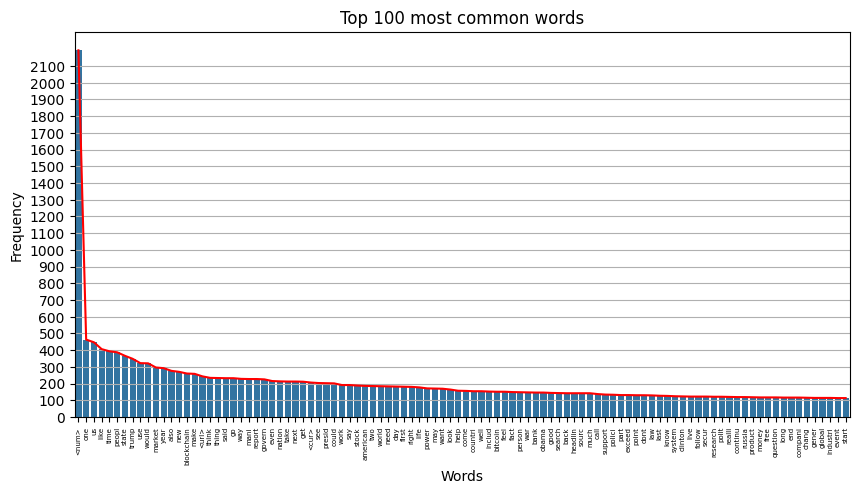

In [21]:

url_freq = vocab.get("<url>",0)
date_freq = vocab.get("<date>",0)
num_freq = vocab.get("<num>",0)
print(f"Number of URLs in the content: {url_freq}")
print(f"Number of dates in the content: {date_freq}")
print(f"Number of numerics in the content: {num_freq}")

plot_freq(vocab, 100)
# plot_freq1(vocab, 100)
